# Implementing New System Matrices

In [1]:
import pytomography
from pytomography.algorithms import OSEM, MLEM
from pytomography.metadata import ObjectMeta, ProjMeta
from pytomography.projectors import SystemMatrix
from pytomography.likelihoods import NegativeMSELikelihood
import matplotlib.pyplot as plt
import torch

For now, we'll set `pytomography.device='cpu'` since all the objects we'll be creating/testing on will be on CPU, but this can be changed (provided all created objects are placed on GPU).

In [2]:
pytomography.device = 'cpu'

This tutorial demonstrates how to implement new system matrices in PyTomography that interface with all the available likelihoods/reconstruction algorithms. We will consider a very simple scenario of an imaging system where 

* data is acquired at two angles (0 and 90 degrees)
* detector consists of an MxM grid that perfectly aligns with an object of shape $M \times M \times M$
* each detector pixel has a different sensitivity $s_j$

The value of each pixel is thus

$$ p_j = s_j \sum_{i \in \text{line}_j} x_i$$

<img src="../images/example_scanner_sm.png"  width="500">



 We'll call this system the **Example Scanner**, (or *EXS* for short) 

In [3]:
M = 3
object_meta = ObjectMeta(dr=(1.5,1.5,1.5), shape=(M,M,M))

The objects we consider thus have dimensions of $3 \times 3 \times 3$ with voxel dimensions of $1.5 \times 1.5 \times 1.5$. The units of the voxel dimensions can be whatever (mm/cm): their units are defined by the system matrix.

# Example 1: Non-ListMode

## Metadata

We'll start by creating a projection metadata class which will interface with the system matrix
* It should be a subclass of the `ProjMeta` class of PyTomography

In [4]:
class EXSProjMeta(ProjMeta):
    def __init__(self, M, sensitivity_factor):
        self.M = M
        self.sensitivity_factor = sensitivity_factor
        if (sensitivity_factor.shape[0]!=M)*(sensitivity_factor.shape[1]!=M):
            raise ValueError("sensitivity_factor should have side dimensions M")

In [5]:
M = object_meta.shape[0]
# Note: the sensitivty factor is the same for each projection angle, a single detector is "rotating" between angle 0 and 90
sensitivity_factor = torch.ones((M,M))+0.3*torch.rand((M,M))
proj_meta = EXSProjMeta(M, sensitivity_factor)

## System Matrix

### Part 1: Understanding the Forward/Backward PRojections

Before we begin to build the system matrix, lets understand the operations required to implement this system matrix. 

* Forward projection requires summing the object along its $x$-axis and $y$-axis respectively, and then concatenating together.
* In PyTomography, our object is 3D, so it's shape is `[Lx,Ly,Lz]`; our projections have shape `[2,M,M]`

In [6]:
sample_object = torch.rand(object_meta.shape) 
# Sum object along x to get projection at 0 degrees
sample_projection_0degrees = sample_object.sum(dim=0) * proj_meta.sensitivity_factor
# Sum object along y to get projection at 90 degrees
sample_projection_90degrees = sample_object.sum(dim=1) * proj_meta.sensitivity_factor
# Concatenate to get the full set of projections
sample_projections = torch.stack([sample_projection_0degrees, sample_projection_90degrees], dim=0)
sample_projections.shape

torch.Size([2, 3, 3])

Let's plot the projections at each angle

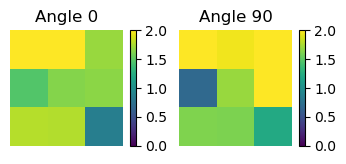

In [7]:
plt.figure(figsize=(4,1.5))
plt.subplot(121)
plt.pcolormesh(sample_projections[0].cpu().T, vmin=0, vmax=2)
plt.colorbar()
plt.axis('off')
plt.title('Angle 0')
plt.subplot(122)
plt.pcolormesh(sample_projections[1].cpu().T, vmin=0, vmax=2)
plt.colorbar()
plt.axis('off')
plt.title('Angle 90')
plt.show()

* Back projection: The transpose of summing along X and Y is duplication along X and Y

In [8]:
# First adjust projections by sensitivity factor
sample_projections_angle_0_sensitivity_adjusted = sample_projections[0]*proj_meta.sensitivity_factor
# Back project at angle 0 by duplication
sample_object_BP_angle0 = sample_projections_angle_0_sensitivity_adjusted.unsqueeze(0).repeat(object_meta.shape[0],1,1)
# Back project at angle 90 by duplication
sample_projections_angle_90_sensitivity_adjusted = sample_projections[1]*proj_meta.sensitivity_factor
sample_object_BP_angle90 = sample_projections_angle_90_sensitivity_adjusted.unsqueeze(1).repeat(1,object_meta.shape[0],1)
# Back projected object is sum of each
sample_object_BP = sample_object_BP_angle0 + sample_object_BP_angle90

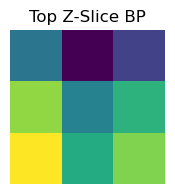

In [9]:
plt.figure(figsize=(2,2))
plt.title('Top Z-Slice BP')
plt.pcolormesh(sample_object_BP[:,:,-1].T)
plt.axis('off')
plt.show()

### Part 2: Implementing The Forward/Backward Projections in the System Matrix Class

We can now create a system matrix class that implements forward and back projection

* We inherit from the `SystemMatrix` class of PyTomography
* The method for forward projection should be called `forward`, while the method for back projection should be called `backward`

In [10]:
class EXSSystemMatrix(SystemMatrix):
    def forward(self, object, subset_idx = None):
        projection_0degrees = object.sum(dim=0)
        projection_90degrees = object.sum(dim=1)
        projections = torch.stack([projection_0degrees, projection_90degrees], dim=0)
        projections *= self.proj_meta.sensitivity_factor
        return projections
    def backward(self, projections, subset_idx = None):
        object_BP_angle0 = (projections[0]*self.proj_meta.sensitivity_factor).unsqueeze(0).repeat(self.proj_meta.M,1,1)
        object_BP_angle90 = (projections[1]*self.proj_meta.sensitivity_factor).unsqueeze(1).repeat(1,self.proj_meta.M,1)
        object_BP = object_BP_angle0 + object_BP_angle90
        return object_BP

This system matrix can now be used for forward/backward projection

In [11]:
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)
FP = system_matrix.forward(sample_object)
BP = system_matrix.forward(sample_object)

In order to use the system matrix in reconstruction algorithms, one of the requirements is the computation of a normalization factor $H^T 1$. For this, we need to define the `compute_normalization_factor` method:

In [12]:
class EXSSystemMatrix(SystemMatrix):
    def compute_normalization_factor(self):
        # A clever implementation of this function will only compute the normalization factor once, and then store it for future use (e.g. using a boolean flag)
        norm_projections = torch.ones((2,self.proj_meta.M, self.proj_meta.M))
        return self.backward(norm_projections)
    def forward(self, object, subset_idx = None):
        projection_0degrees = object.sum(dim=0)
        projection_90degrees = object.sum(dim=1)
        projections = torch.stack([projection_0degrees, projection_90degrees], dim=0)
        projections *= self.proj_meta.sensitivity_factor
        return projections
    def backward(self, projections, subset_idx = None):
        object_BP_angle0 = (projections[0]*self.proj_meta.sensitivity_factor).unsqueeze(0).repeat(self.proj_meta.M,1,1)
        object_BP_angle90 = (projections[1]*self.proj_meta.sensitivity_factor).unsqueeze(1).repeat(1,self.proj_meta.M,1)
        object_BP = object_BP_angle0 + object_BP_angle90
        return object_BP

Then we can compute the normalization factor as follows:

In [13]:
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)
norm_factor = system_matrix.compute_normalization_factor()

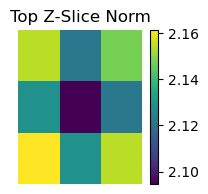

In [14]:
plt.figure(figsize=(2,2))
plt.title('Top Z-Slice Norm')
plt.pcolormesh(norm_factor[:,:,-1].T)
plt.colorbar()
plt.axis('off')
plt.show()

Now that the system matrix has been defined, we can reconstruct using the available reconstruction algorithms (up to this point, we haven't defined any subset functionality, so we can only use non-subset based algorithms) 

In [15]:
sample_object = torch.rand(object_meta.shape) # object has batch dimension
sample_projections = system_matrix.forward(sample_object)

In [16]:
# Define system matrix
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)
# Define likelihood that characterizes measured data (for SPECT/PET, this is PoissonLog, but here we'll use NegativeMSE)
likelihood = NegativeMSELikelihood(system_matrix, projections=sample_projections, scaling_constant=0.01)
# Define 
reconstruction_algorithm = MLEM(likelihood)

In [17]:
recon = reconstruction_algorithm(n_iters=40)

In this case our system matrix is underdetermined so we have no way of ensuring we get the right solution

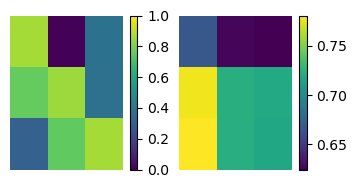

In [18]:
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.pcolormesh(sample_object[:,:,0], vmin=0, vmax=1)
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(recon[:,:,0])
plt.axis('off')
plt.colorbar()

### Part 3: Incorporating Subsets

Up until now, we've ignored the `subset_idx` which specifies how projection data can be split into subsets in ordered subset based reconstruction algorithms. In such algorithms, the projection data is split up into disjoint subsets: in SPECT/PET, one typically partitions using the projection angle. We will do the same thing here, giving the option of `subset_idx=0` for the first projection angle and `subset_idx=1` for the second:

In [19]:
class EXSSystemMatrix(SystemMatrix):
    def compute_normalization_factor(self):
        norm_projections = torch.ones((2,self.proj_meta.M, self.proj_meta.M))
        return self.backward(norm_projections)
    def forward(self, object, subset_idx = None):
        projection_0degrees = object.sum(dim=0)
        projection_90degrees = object.sum(dim=0)
        if subset_idx==0:
            projections = projection_0degrees
        elif subset_idx==1:
            projections = projection_90degrees
        else:
            projections = torch.stack([projection_0degrees, projection_90degrees], dim=0)
        projections *= self.proj_meta.sensitivity_factor
        return projections
    def backward(self, proj, subset_idx = None):
        # Back projection expects projections in their subset
        if subset_idx is not None:
            object_BP = (proj[0]*self.proj_meta.sensitivity_factor).unsqueeze(subset_idx).repeat_interleave(self.proj_meta.M, subset_idx)
        else:
            object_BP_angle0 = (proj[0]*self.proj_meta.sensitivity_factor).unsqueeze(0).repeat(self.proj_meta.M,1,1)
            object_BP_angle90 = (proj[1]*self.proj_meta.sensitivity_factor).unsqueeze(1).repeat(1,self.proj_meta.M,1)
            object_BP = object_BP_angle0 + object_BP_angle90
        return object_BP

In [20]:
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)
FP_subset0 = system_matrix.forward(sample_object, subset_idx=0)
FP_subset1 = system_matrix.forward(sample_object, subset_idx=1)
BP_subset0 = system_matrix.backward(FP_subset0, subset_idx=0)
BP_subset1 = system_matrix.backward(FP_subset0, subset_idx=1)

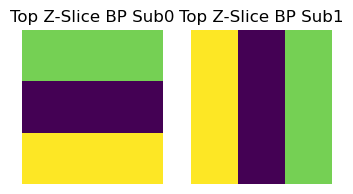

In [21]:
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.title('Top Z-Slice BP Sub0')
plt.pcolormesh(BP_subset0[:,:,-1].T)
plt.axis('off')
plt.subplot(122)
plt.title('Top Z-Slice BP Sub1')
plt.pcolormesh(BP_subset1[:,:,-1].T)
plt.axis('off')
plt.show()

There are a couple other methods we need to implement for subset based image reconstruction algorithms:
* `set_n_subsets`: Sets the number of "subsets" used in an iterative reconstruction algorithm. This requires partitioning the projection data into N distinct subsets. In general, the way in which this is done depends on the particular imaging modality (in SPECT/PET, one typically partitions using the projection angle).In our case, we have only set up our forward/back projectors to consider 2 subsets (we only have two possible angles). More advanced system matrices will need to consider implementation of arbitrary numbers of subsets 
* `get_projection_subset`: Returns the projection data corresponding to the ith subset 
* `get_weighting_subset`: This is used for scaling prior functions used in Bayesian reconstruction algorithms. It should be equal to the fraction of data elements in the particular subset. (For $N$ even subsets, this factor is $1/N$ for each subset, but sometimes the subsets aren't even)
* We need to modify `compute_normalization_factor` so it can get the normalization factor of the $m$ th subset

In [22]:
class EXSSystemMatrix(SystemMatrix):
    # ----
    # NEW METHODS
    # ----
    def set_n_subsets(self, n_subsets):
        self.n_subsets = n_subsets
    def get_projection_subset(self, projections, subset_idx):
        # Called when n_subsets>1 in internal pytomography code, in this case, assumes 2 subsets since thats the only possible number of subsets we have. In general, this should split data evenly (see SPECTSystemMatrix source code)
        return projections[subset_idx].unsqueeze(0)
    def compute_normalization_factor(self, subset_idx = None):
        # This function generally looks the same for all system matrices
        norm_projections = torch.ones((2,self.proj_meta.M, self.proj_meta.M))
        if subset_idx is not None:
            norm_projections = self.get_projection_subset(norm_projections, subset_idx)
        return self.backward(norm_projections, subset_idx)
    def get_weighting_subset(self, subset_idx):
        if subset_idx is None:
            return 1
        elif self.n_subsets==2:
            return 0.5 # equal weighting in this case, in general need to be careful with this
    # ----
    # SAME AS PREVIOUS
    # ----
    def forward(self, object, subset_idx = None):
        projection_0degrees = object.sum(dim=0)
        projection_90degrees = object.sum(dim=0)
        if subset_idx==0:
            projections = projection_0degrees
        elif subset_idx==1:
            projections = projection_90degrees
        else:
            projections = torch.stack([projection_0degrees, projection_90degrees], dim=0)
        projections *= self.proj_meta.sensitivity_factor
        return projections
    def backward(self, proj, subset_idx = None):
        # Back projection expects projections in their subset
        if subset_idx is not None:
            object_BP = (proj[0]*self.proj_meta.sensitivity_factor).unsqueeze(subset_idx).repeat_interleave(self.proj_meta.M, subset_idx)
        else:
            object_BP_angle0 = (proj[0]*self.proj_meta.sensitivity_factor).unsqueeze(0).repeat(self.proj_meta.M,1,1)
            object_BP_angle90 = (proj[1]*self.proj_meta.sensitivity_factor).unsqueeze(1).repeat(1,self.proj_meta.M,1)
            object_BP = object_BP_angle0 + object_BP_angle90
        return object_BP

In [23]:
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)

Our system matrix can now be used in reconstruction algorithms. Let's reconstruct our simulated data. Like the tutorials online, we now create a likelihood function and then a reconstruction algorithm:

In [24]:
sample_object = torch.rand(object_meta.shape) # object has batch dimension
sample_projections = system_matrix.forward(sample_object)

In [25]:
system_matrix = EXSSystemMatrix(object_meta=object_meta, proj_meta=proj_meta)
likelihood = NegativeMSELikelihood(system_matrix, projections=sample_projections, scaling_constant=0.01)
reconstruction_algorithm = OSEM(likelihood)

In [26]:
recon = reconstruction_algorithm(n_iters=40, n_subsets=2)

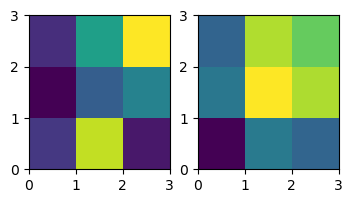

In [27]:
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.pcolormesh(sample_object[:,:,-1])
plt.subplot(122)
plt.pcolormesh(recon[:,:,-1])

# Example 2: List Mode System Matrices

Modalities containing listmode data can also be implemented in PyTomography; their implementation may look slightly different than above, however. Regardless, if implemented properly, they are still usable with all available reconstruction algorithms

For our simple imaging system, listmode data might be stored via a list of integers where each integer specifies a given pixel in projection space. Since we have 2 projections, each with $M \times M$ pixels, the total number of detector elements is $2M^2$.

We can simulate 100 random events as follows (in reality, a more sophisticated program, such as GATE, would be required to give a proper distribution according to a specific phantom/source distribution)

In [28]:
detector_ids = torch.randint(low=0, high=2*M**2, size=(400,))
detector_ids

tensor([ 9,  0,  8,  2, 10,  5, 12,  0,  7, 16, 13,  4, 15,  8,  5, 13, 12,  5,
         6, 12,  0, 10, 13, 13, 16,  7, 15, 11, 15, 16,  0,  1,  0,  2, 15,  8,
         1, 11, 14,  7,  7,  6,  9,  4,  0,  9,  3,  7, 11,  2,  4,  2,  9, 17,
         1,  3,  5, 11,  4,  2,  5, 15, 11,  9, 16,  0, 14, 14,  2, 17,  3, 13,
         8,  9,  5,  8,  0,  2,  0,  0, 11,  7, 17, 17, 13,  4,  7,  6,  4,  8,
         2,  3, 14,  1, 16,  7, 13,  6,  7, 13,  0, 12,  7, 14,  5, 12,  5, 10,
         6, 14,  9,  4, 14,  1,  0,  1,  9,  6, 15,  4,  6,  3,  1,  7, 13, 11,
        11, 10, 11, 14, 10, 11,  6,  9, 15,  2, 11, 10,  4,  6,  6,  4,  8, 14,
         6, 16,  8, 10, 15, 13,  5,  1,  3, 10,  3, 14, 13, 12,  2,  8,  8,  6,
         0,  5, 16, 16, 17,  9, 17,  2, 16,  6,  1, 10, 16,  2, 13, 16,  2,  2,
         5, 12, 14,  6,  4, 16,  3,  9, 15,  5,  5,  4, 14, 14,  2,  0,  9,  2,
        16,  2,  5,  1,  1, 13,  5,  7,  1, 13,  9, 10, 10, 10, 10, 11, 11,  1,
         6,  4,  1,  4,  0, 13, 16,  3, 

## MetaData

Each integer corresponds to a given detector element where a count has been measured.First, we may want to generate a lookup table for these integer values and corresponding detector coordinates:

In [29]:
scanner_LUT = torch.cartesian_prod(
    torch.tensor([0,1]), # Angle
    torch.arange(M), # row
    torch.arange(M), # column
)
scanner_LUT

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 2],
        [0, 2, 0],
        [0, 2, 1],
        [0, 2, 2],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2]])

This lookup table gives the angle index, row index, and column index in projection space for each detector ID. For example, if we want the location corresponding to detector ID 11:

In [30]:
scanner_LUT[5]

tensor([0, 1, 2])

Similarily, if we wanted the location corresponding to the first 5 measured events:

In [31]:
scanner_LUT[detector_ids[0:5]]

tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 2, 2],
        [0, 0, 2],
        [1, 0, 1]])

We can also get the sensitivity factor for each listmode event:

In [32]:
sensitivity_factor[*scanner_LUT[detector_ids][:,:2].T]

tensor([1.1857, 1.0389, 1.0806, 1.0389, 1.1857, 1.1392, 1.1079, 1.0389, 1.0806,
        1.0473, 1.1079, 1.1392, 1.0473, 1.0806, 1.1392, 1.1079, 1.1079, 1.1392,
        1.0806, 1.1079, 1.0389, 1.1857, 1.1079, 1.1079, 1.0473, 1.0806, 1.0473,
        1.1857, 1.0473, 1.0473, 1.0389, 1.0389, 1.0389, 1.0389, 1.0473, 1.0806,
        1.0389, 1.1857, 1.1079, 1.0806, 1.0806, 1.0806, 1.1857, 1.1392, 1.0389,
        1.1857, 1.1392, 1.0806, 1.1857, 1.0389, 1.1392, 1.0389, 1.1857, 1.0473,
        1.0389, 1.1392, 1.1392, 1.1857, 1.1392, 1.0389, 1.1392, 1.0473, 1.1857,
        1.1857, 1.0473, 1.0389, 1.1079, 1.1079, 1.0389, 1.0473, 1.1392, 1.1079,
        1.0806, 1.1857, 1.1392, 1.0806, 1.0389, 1.0389, 1.0389, 1.0389, 1.1857,
        1.0806, 1.0473, 1.0473, 1.1079, 1.1392, 1.0806, 1.0806, 1.1392, 1.0806,
        1.0389, 1.1392, 1.1079, 1.0389, 1.0473, 1.0806, 1.1079, 1.0806, 1.0806,
        1.1079, 1.0389, 1.1079, 1.0806, 1.1079, 1.1392, 1.1079, 1.1392, 1.1857,
        1.0806, 1.1079, 1.1857, 1.1392, 

With this in mind, we can define our new listmode projection metadata class:

In [33]:
class EXSListmodeProjMeta(ProjMeta):
    def __init__(self, shape, scanner_LUT, detector_ids, sensitivity_factor):
        self.scanner_LUT = scanner_LUT
        self.detector_ids = detector_ids
        self.sensitivity_at_ids = sensitivity_factor[*scanner_LUT[:,1:].T]
        self.shape = shape
        if (sensitivity_factor.shape[0]!=M)*(sensitivity_factor.shape[1]!=M):
            raise ValueError("sensitivity_factor should have side dimensions M")
proj_meta_listmode = EXSListmodeProjMeta((2,M,M), scanner_LUT, detector_ids, sensitivity_factor)

Lets now implement the forward/backward methods of the system matrix. We'll start with forward projection, which forward projects an object to each `id` form the listmode data.

In [34]:
class EXSListmodeSystemMatrix(SystemMatrix):
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)

In [35]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
sample_object = torch.rand(object_meta.shape) # object has batch dimension
sample_projections = system_matrix.forward(sample_object)
sample_projections

tensor([2.0330, 1.6112, 1.8148, 1.7479, 0.9122, 1.9431, 1.9063, 1.6112, 1.2265,
        1.7308, 2.8246, 2.2089, 1.3294, 1.8148, 1.9431, 2.8246, 1.9063, 1.9431,
        1.6145, 1.9063, 1.6112, 0.9122, 2.8246, 2.8246, 1.7308, 1.2265, 1.3294,
        1.3073, 1.3294, 1.7308, 1.6112, 2.0206, 1.6112, 1.7479, 1.3294, 1.8148,
        2.0206, 1.3073, 1.8169, 1.2265, 1.2265, 1.6145, 2.0330, 2.2089, 1.6112,
        2.0330, 2.1111, 1.2265, 1.3073, 1.7479, 2.2089, 1.7479, 2.0330, 2.3819,
        2.0206, 2.1111, 1.9431, 1.3073, 2.2089, 1.7479, 1.9431, 1.3294, 1.3073,
        2.0330, 1.7308, 1.6112, 1.8169, 1.8169, 1.7479, 2.3819, 2.1111, 2.8246,
        1.8148, 2.0330, 1.9431, 1.8148, 1.6112, 1.7479, 1.6112, 1.6112, 1.3073,
        1.2265, 2.3819, 2.3819, 2.8246, 2.2089, 1.2265, 1.6145, 2.2089, 1.8148,
        1.7479, 2.1111, 1.8169, 2.0206, 1.7308, 1.2265, 2.8246, 1.6145, 1.2265,
        2.8246, 1.6112, 1.9063, 1.2265, 1.8169, 1.9431, 1.9063, 1.9431, 0.9122,
        1.6145, 1.8169, 2.0330, 2.2089, 

Note that our "projections" are now in listmode format: namely, these correspond to forward projected values at all the "detector_ids" which formed our listmode dataset. The backward method is analogous:

In [36]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # SAME AS ABOVE
    # ----
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    # ---
    # NEW CODE
    # ---
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        projections *= self.proj_meta.sensitivity_at_ids[self.proj_meta.detector_ids]
        for i, detector_id in enumerate(detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object

In [37]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
sample_object = torch.rand(object_meta.shape) # object has batch dimension
FP = system_matrix.forward(sample_object)
BP = system_matrix.backward(FP)

The computation of the normalization factor for listmode reconstruction is slightly more nuanced since it requires defining a "projection of all 1s". In this case, the projection of all 1s corresponds to a value of 1 in each location of the scanner LUT.

* This is distinct from the regular forward/back projection which projects to all the measured detector IDs. For example, if we measure 1000 events, then forward projection produces an array of size 1000, and back projection takes in projections of size 1000 to produce an object. Computation of the normalization factor, however, takes in detector IDs corresponding to each detector, in the case $M=3$, it would take in 18 detector IDs

In [38]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # SAME AS ABOVE
    # ----
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        projections *= self.proj_meta.sensitivity_at_ids[self.proj_meta.detector_ids]
        for i, detector_id in enumerate(detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object
    # ----
    # NEW CODE
    # ----
    def compute_normalization_factor(self):
        norm_BP = torch.zeros(object_meta.shape)
        # Now we loop through unique detector ids instead
        unique_detector_ids = torch.arange(scanner_LUT.shape[0])
        for i, detector_id in enumerate(unique_detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                norm_BP[:,coord[1],coord[2]] += sensitivity_factor_i
            elif coord[0]==1: # If angle 90:
                norm_BP[coord[1],:,coord[2]] += sensitivity_factor_i
        return norm_BP

In [39]:
sensitivity_factor

tensor([[1.0389, 1.1392, 1.0806],
        [1.1857, 1.1079, 1.0473],
        [1.2224, 1.2087, 1.0737]])

In [40]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
norm_BP = system_matrix.compute_normalization_factor()

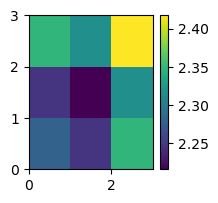

In [41]:
plt.figure(figsize=(2,2))
plt.pcolormesh(norm_BP[:,:,1])
plt.colorbar()

Now we can use the listmode system matrix with the rest of the library.

**For list mode system matrices, we no longer need to provide `projections` to the likelihood function**

In [42]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
likelihood = NegativeMSELikelihood(system_matrix, scaling_constant=0.01)
reconstruction_algorithm = OSEM(likelihood)

In [43]:
recon = reconstruction_algorithm(n_iters=40)

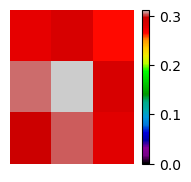

In [44]:
plt.figure(figsize=(2,2))
plt.pcolormesh(recon[:,:,1], vmin=0, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()

## Part 2: Incorporating Subsets

Incorporating subsets is slightly more intuitive with listmode data. In this case, we split up all the detected events into $N$ approximately equal subsets using the `torch.tensor_split` function

In [45]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # NEW CODE
    # ----
    def set_n_subsets(self, n_subsets):
        self.n_subsets = n_subsets
        idx = torch.arange(proj_meta_listmode.detector_ids.shape[0])
        self.subset_indices_array = torch.tensor_split(idx, self.n_subsets)
    def get_projection_subset(self, projections, subset_idx):
        # Needs to consider cases where projection is simply a 1 element tensor in the numerator, but also cases of scatter where it is a longer tensor
        if (projections.shape[0]>1)*(subset_idx is not None):
            subset_indices = self.subset_indices_array[subset_idx]
            proj_subset = projections[subset_indices]
        else:
            proj_subset = projections
        return proj_subset
    def get_weighting_subset(self, subset_idx):
        if subset_idx is None:
            return 1
        else:
            # Fraction of events in the subset
            return self.subset_indices_array[subset_idx].shape[0] / proj_meta_listmode.detector_ids.shape[0]
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        if subset_idx is None:
            detector_ids_subset = self.proj_meta.detector_ids
        else:
            detector_ids_subset = self.proj_meta.detector_ids[self.subset_indices_array[subset_idx]]
        for i, detector_id in enumerate(detector_ids_subset):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        if subset_idx is None:
            detector_ids_subset = self.proj_meta.detector_ids
        else:
            detector_ids_subset = self.proj_meta.detector_ids[self.subset_indices_array[subset_idx]]
        projections *= self.proj_meta.sensitivity_at_ids[detector_ids_subset]
        for i, detector_id in enumerate(detector_ids_subset):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object
    def compute_normalization_factor(self, subset_idx=None):
        fraction_considered = self.get_weighting_subset(subset_idx)
        norm_BP = torch.zeros(object_meta.shape)
        # Now we loop through unique detector ids instead
        unique_detector_ids = torch.arange(scanner_LUT.shape[0])
        for i, detector_id in enumerate(unique_detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                norm_BP[:,coord[1],coord[2]] += sensitivity_factor_i
            elif coord[0]==1: # If angle 90:
                norm_BP[coord[1],:,coord[2]] += sensitivity_factor_i
        return norm_BP * fraction_considered

In [46]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
likelihood = NegativeMSELikelihood(system_matrix, scaling_constant=0.01)
reconstruction_algorithm = OSEM(likelihood)

In [47]:
recon_2subsets = reconstruction_algorithm(n_iters=20, n_subsets=2)
reconstruction_algorithm = OSEM(likelihood)
recon_1subset = reconstruction_algorithm(n_iters=40)

Now lets plot the reconstructions:

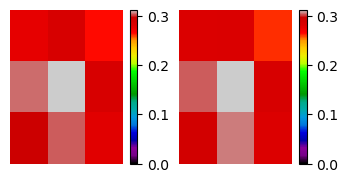

In [48]:
max_value = max([recon_1subset[:,:,1].max().item(), recon_1subset[:,:,1].max().item()])
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.pcolormesh(recon_1subset[:,:,1], vmin=0, vmax=max_value, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(recon_2subsets[:,:,1], vmin=0, vmax=max_value, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()

For a better imaging system (we're not collecting nearly enough angles here), these two images should look very similar.